# CNN model to distinguish between Pneumonia, Covid infected and healthy lungs

The purpose of this notebook is to attempt to build a robust model that can assist in using X-ray images to distinguish between lungs that are healthy and lungs that are infected with Covid or Pneumonia. In order to do so the dataset given is explored, and various different data augmentation methods are used to show how certain problems can be solved. The notebook also has several methods to prevent overfitting which is one of the largest concerns when it comes to building a deep neural network.

## Importing all the libraries


First all the necessary libraries are imported

In [1]:
import numpy as np
from numpy import sqrt
from numpy import argmax

import pandas as pd
import seaborn as sns

%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_white"
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import scipy
from scipy.stats import pearsonr
from scipy.stats import skew
from scipy.stats import kurtosis


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import keras
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.utils import to_categorical


import imgaug.augmenters as iaa

import os

from pathlib import Path

import splitfolders

from skimage.io import imread
from skimage.transform import resize

import cv2

import pickle

## Xray Dataset

The original dataset consisted of a single folder which consisted of three subfolders, one for each of the three different type of x-ray (healthy, pneumonia and covid). The 'splitfolders' library is used to change the layout of the original dataset, such that now the dataset consists of three folders, training, validation and testing data. These directories are each then further split into three folders (test, validation, training).

In [2]:
# Folders are split in the ratios shown

splitfolders.ratio('.\lung_dataset', output="split_dataset", seed=2022, ratio=(.70, 0.15,0.15))

Copying files: 15153 files [00:13, 1134.30 files/s]


In [2]:
# path to dataset
data_dir = Path('.\split_dataset')

# path to train directory
train_dir = data_dir / 'train'

# path to validation directory
val_dir = data_dir / 'val'

# path to test directory
test_dir = data_dir / 'test'



# path to healthy training directory
healthy_cases_dir = train_dir / 'HEALTHY'

# path to pneumonia training directory
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# path to covid training directory
covid_cases_dir = train_dir / 'COVID'



# path to healthy validation directory
healthy_val_dir = val_dir / 'HEALTHY'

# path to pneumonia validation directory
pneumonia_val_dir = val_dir / 'PNEUMONIA'

# path to covid validation directory
covid_val_dir = val_dir / 'COVID'

After the directories are all correctly set, the training and validation images are then loaded.

In [3]:
# Training Data list
training_data = []

# Training Data - Healthy
healthy_cases = healthy_cases_dir.glob('*.png')
for png in healthy_cases:
    training_data.append((png,0))

# Training Data - Pneumonia
pneumonia_cases = pneumonia_cases_dir.glob('*.png')
for png in pneumonia_cases:
    training_data.append((png,1))

# Training Data - Covid
covid_cases = covid_cases_dir.glob('*.png')
for png in covid_cases:
    training_data.append((png,2))

# Shuffles the list
training_data = shuffle(training_data)

# Check the length of the list
print(len(training_data))

10606


In [4]:
# Validation Data list
val_data = []

# Validation Data - Healthy
healthy_cases = healthy_val_dir.glob('*.png')
for png in healthy_cases:
    val_data.append((png,0))

# Validation Data - Pneumonia
pneumonia_cases = pneumonia_val_dir.glob('*.png')
for png in pneumonia_cases:
    val_data.append((png,1))

# Validation Data - Covid
covid_cases = covid_val_dir.glob('*.png')
for png in covid_cases:
    val_data.append((png,2))
    
# Shuffles the list
val_data = shuffle(val_data)

# Check the length of the list
print(len(val_data))

2271


In [5]:
df = pd.DataFrame(training_data, columns=['image', 'label'],index=None)

df.head()

image  label
0  split_dataset\train\PNEUMONIA\Pneumonia (1218)...      1
1     split_dataset\train\HEALTHY\HEALTHY (6421).png      0
2         split_dataset\train\COVID\COVID (1649).png      2
3          split_dataset\train\COVID\COVID (411).png      2
4      split_dataset\train\HEALTHY\HEALTHY (344).png      0

## Data exploration

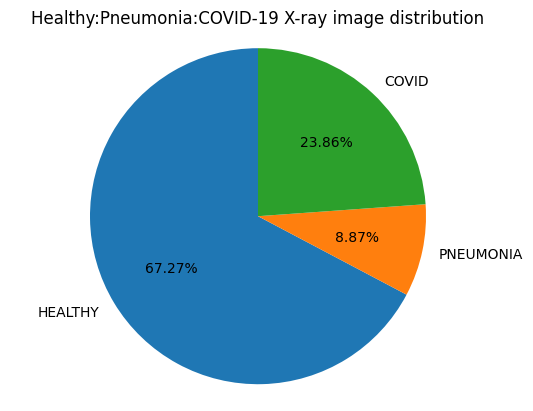

In [8]:
# checking the distribution/balance in our dataset
labels = ['HEALTHY', 'PNEUMONIA', 'COVID']

num_healthy = round(df['label'].value_counts()[0]/len(df) * 100, 2)
num_pneumonia = round(df['label'].value_counts()[1]/len(df) * 100, 2)
num_covid = round(df['label'].value_counts()[2]/len(df) * 100, 2)

sizes = [num_healthy, num_pneumonia, num_covid]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)
ax.axis('equal')
ax.set_title('Healthy:Pneumonia:COVID-19 X-ray image distribution')

plt.show()

The dataset can be seen to be quite imbalanced

Let's first take a look at a sample of the images to see if they have loaded in correctly.

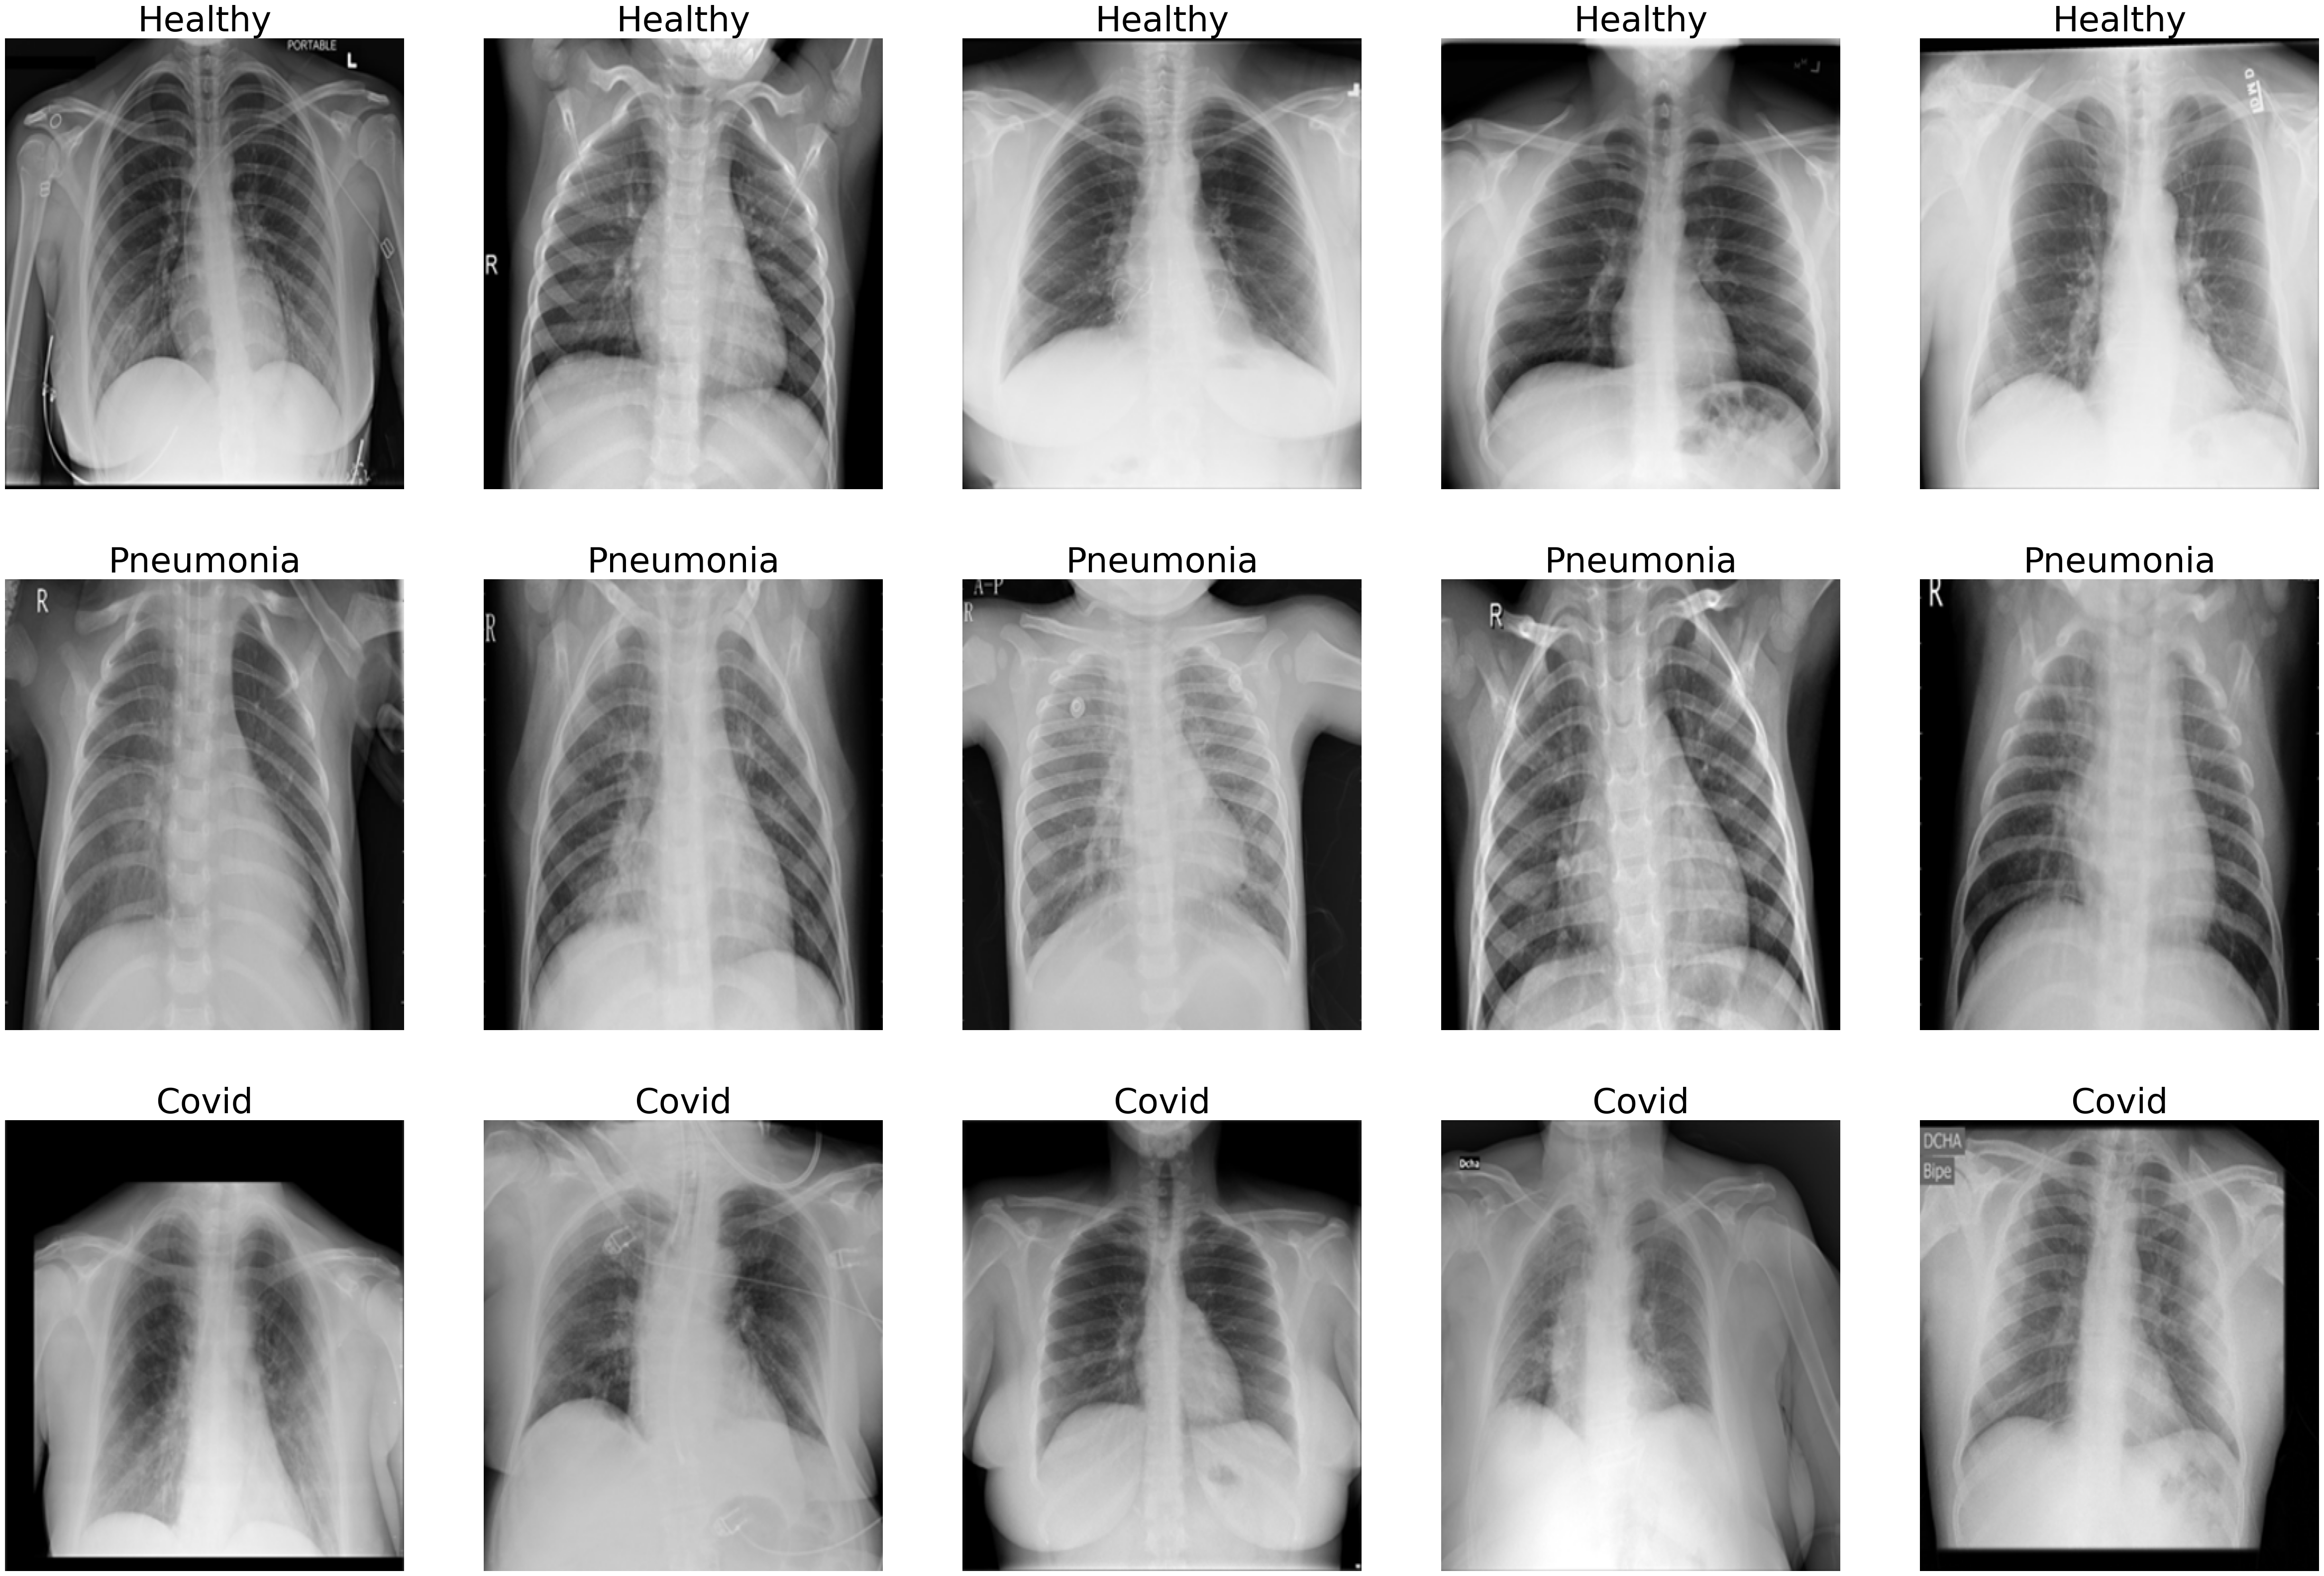

In [9]:
healthy_sample = (df[df['label']==0]['image'].iloc[:5]).tolist()
pneumonia_sample = (df[df['label']==1]['image'].iloc[:5]).tolist()
covid_sample = (df[df['label']==2]['image'].iloc[:5]).tolist()

img_sample = healthy_sample + pneumonia_sample + covid_sample
del healthy_sample, pneumonia_sample, covid_sample

ay, ax = plt.subplots(3,5, figsize=(60,40))

for i in range(15):
    img = cv2.imread(str(img_sample[i]))
    ax[i//5, i%5].imshow(img)
    
    if i<5:
        ax[i//5, i%5].set_title("Healthy", fontsize=50)
        
    elif 5 <= i < 10:
        ax[i//5, i%5].set_title("Pneumonia", fontsize=50)
        
    else:
        ax[i//5, i%5].set_title("Covid", fontsize=50)
        
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')

plt.show()


This sample shows the difficulty of telling the difference between the x-rays with a naked eye. Let's take a look at some images that can cause difficulties for the model to classify.

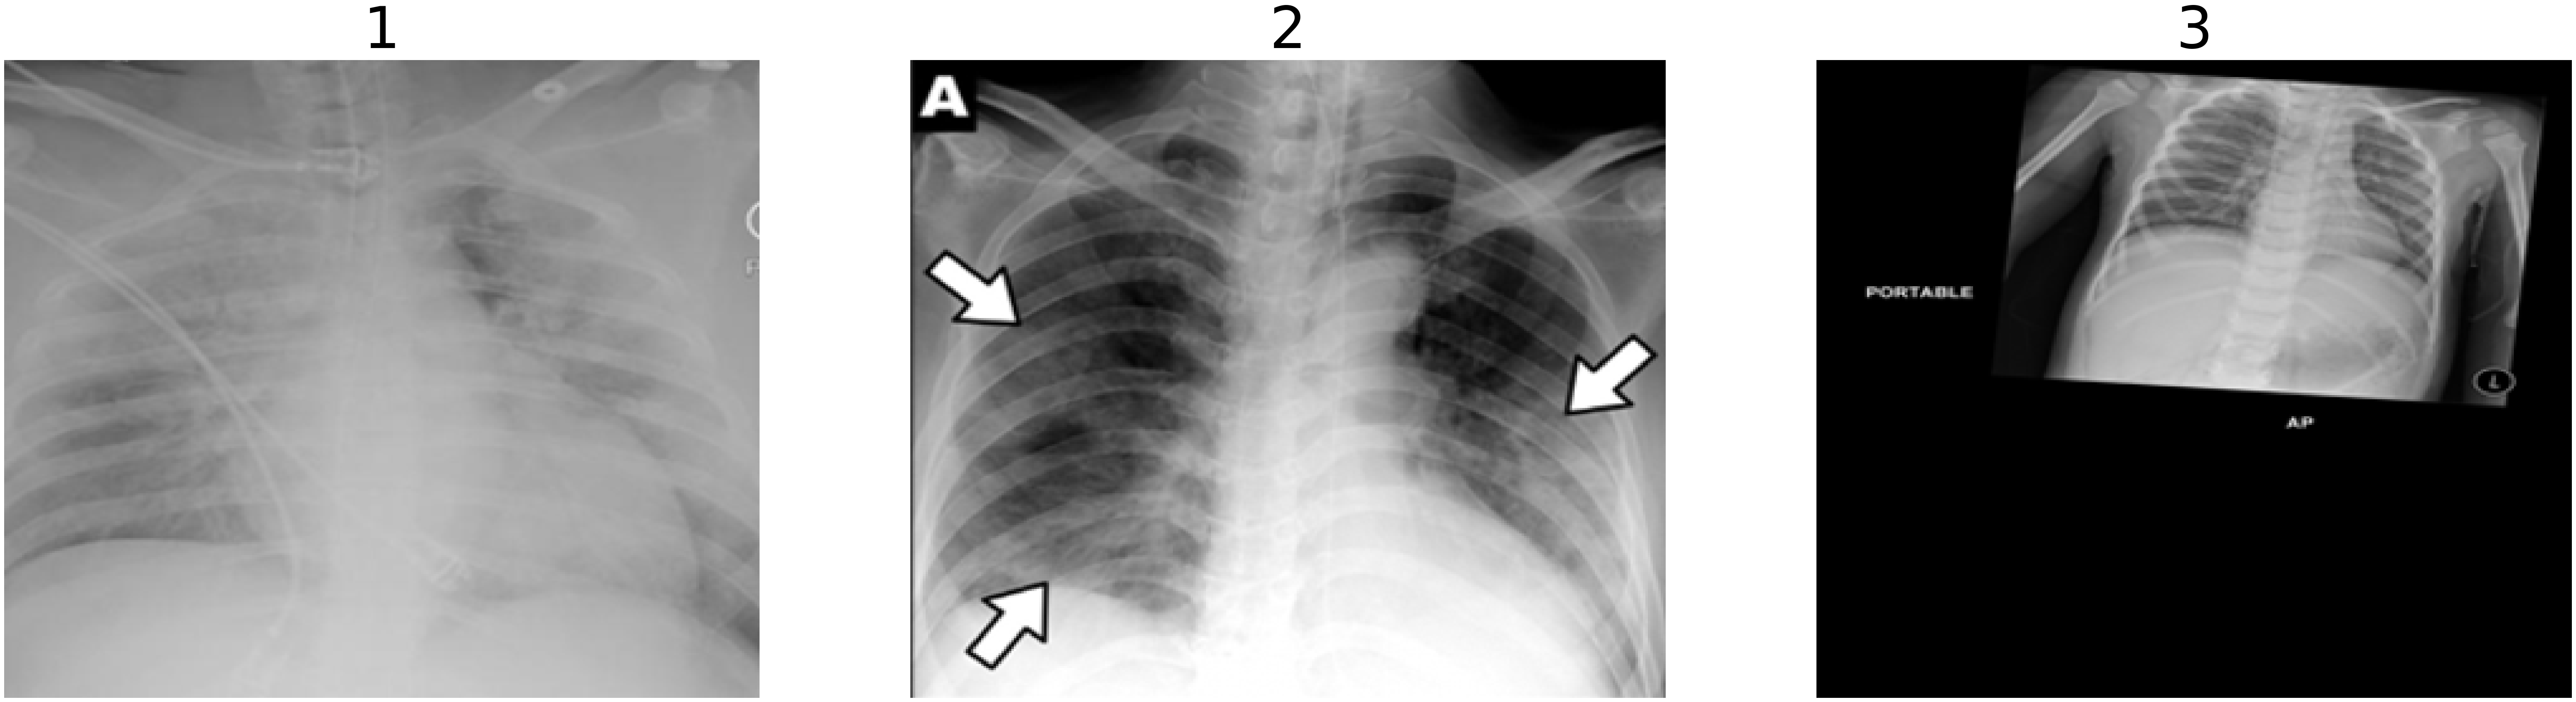

In [10]:
a, ax = plt.subplots(1,3, figsize=(80,20))

path0 = Path('./split_dataset/val/COVID/COVID (508).png')

path1 = Path('./split_dataset/test/COVID/COVID (449).png')

path2 = Path('./split_dataset/train/HEALTHY/HEALTHY (2880).png')

paths = [path0,path1,path2]

img = cv2.imread(str(path2))
ax[1].imshow(img,cmap='bone')


for i in range(3):

    img = cv2.imread(str(paths[i]))
    ax[i].imshow(img)
    
    ax[i].set_title(str(i+1), fontsize=100)  
    ax[i].axis('off')
    ax[i].set_aspect('auto')


#ax.axis('off')

Here you can see a few of the problems present throughout the dataset:

1. Low contrast images
2. Images with letters and symbols
3. Images too zoomed out


To create an accurate model that can overcome these problems data augmentation will need to be implemented. 

### Low contrast images

Low contrast images are a problem for CNN's as the difference in intesnsity between the pixels of the key features and the background is small, which makes it difficult for the network to distinguish between the two. This wiil then naturally lead to poor performance so this is the first thing that will need to be tackled.

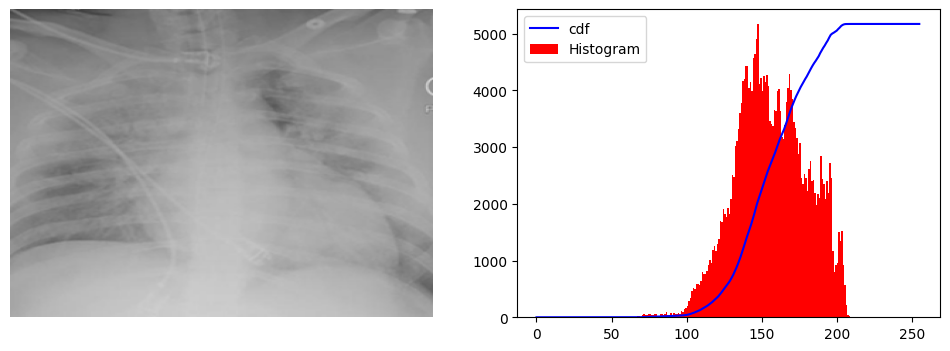

In [11]:
low_contrast_img = cv2.imread(str(path0))
hist,bins = np.histogram(low_contrast_img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig, ax = plt.subplots(1,2,figsize=(12, 4))


ax[0].imshow(low_contrast_img)
    

ax[0].axis('off')
ax[0].set_aspect('auto')




ax[1].plot(cdf_normalized, color = 'b')
ax[1].hist(low_contrast_img.flatten(),256,[0,256], color = 'r')
#ax[1].xlim([0,256])
ax[1].legend(('cdf','Histogram'), loc = 'upper left')
plt.show()

Above is the image that was previously used and it's corresponding pixel intensity distribution. It's evident that the majority of the intensities range between 125-175, and peaking around 150. The left and right side also don't have any values, hence this shows that the image has poor pixel contrast. To resolve this issue histogram equilization is used. Histrogram equilization aims to flatten out the intensity distribution by mapping the old intensity values to new values by using the cdf (cumilative distribution function). The initial cdf is a curve and the equilization transforms this curve into a linear function which increases the overall contrast.

(299, 299)


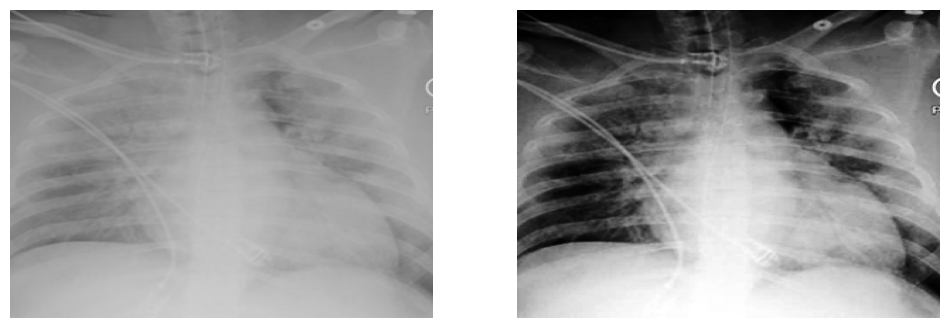

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))

ax[0].imshow(low_contrast_img)
ax[0].axis('off')
ax[0].set_aspect('auto')

#print(low_contrast_img.shape)

high_contrast_img = cv2.cvtColor(low_contrast_img, cv2.COLOR_BGR2GRAY)

high_contrast_img = cv2.equalizeHist(high_contrast_img)


print(high_contrast_img.shape)
ax[1].imshow(high_contrast_img,cmap='gray')
ax[1].axis('off')
ax[1].set_aspect('auto')


The image on the left is how the new image looks after it has been adjusted by histogram equilization. Now the contrast is much greater and the darker areas of the original image are much more pronounced and this will help increase the performance of the CNN.

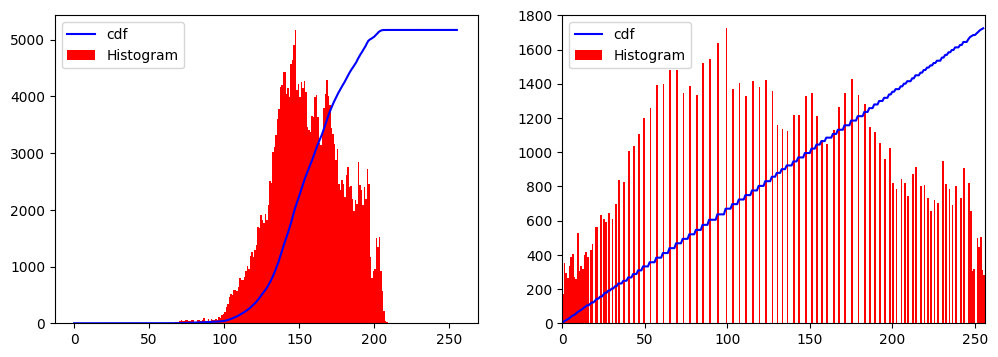

In [14]:


fig, ax = plt.subplots(1,2,figsize=(12, 4),sharey=False)



low_contrast_img = cv2.imread(str(path0))
hist,bins = np.histogram(low_contrast_img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()





ax[0].plot(cdf_normalized, color = 'b')
ax[0].hist(low_contrast_img.flatten(),256,[0,256], color = 'r')
ax[0].legend(('cdf','Histogram'), loc = 'upper left')




hist,bins = np.histogram(high_contrast_img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()




ax[1].plot(cdf_normalized, color = 'b')
ax[1].hist(high_contrast_img.flatten(),256,[0,256], color = 'r')
ax[1].set_ylim(0,1800)
ax[1].set_xlim(0,256)
ax[1].legend(('cdf','Histogram'), loc = 'upper left')
plt.show()

Comparing the original and the new equalized histogram it can be seen that the new histogram spans over the whole range of intensity values. The CDF can also be seen is now linear

## Zoomed Images

Zoomed out images can cause problems for a CNN to accurately classify the image as the image will contain less useful information. In addition features such as edges will be less visibile as well as possibly blend together with other features which can further make it harder to distinguish the image.

(299, 299, 3)


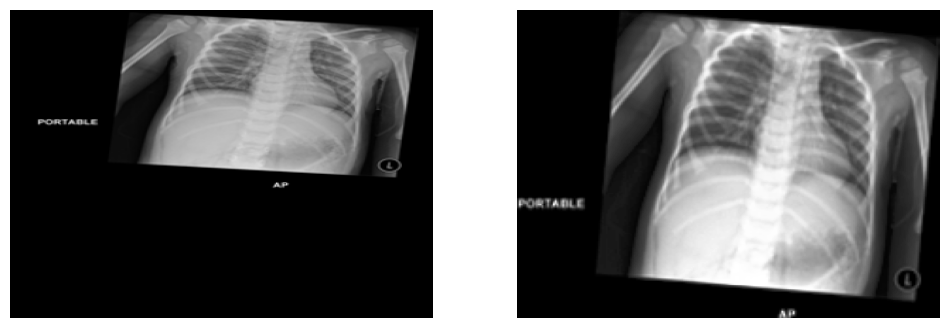

In [15]:

low_contrast_img = cv2.imread(str(path2))

def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
print(low_contrast_img.shape)
cropped = crop(low_contrast_img)
cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
cropped= cv2.resize(cropped,(224,224))



fig, ax = plt.subplots(1,2,figsize=(12, 4))

ax[0].imshow(low_contrast_img,cmap ='gray')
ax[0].axis('off')
ax[0].set_aspect('auto')
cropped = cv2.equalizeHist(cropped)
#print(low_contrast_img.shape)

ax[1].imshow(cropped,cmap='gray')
ax[1].axis('off')
ax[1].set_aspect('auto')


Although the method to remove the black borders doesn't work perfectly due to the writing that is around the x-ray, it still removes a large percentage of it.

## Data augmentation

Other than low contrast images there are other problematic images that need to be dealt with. To deal with these images data augmentation will be implemented. Data augmentation is useful to reduce overfitting by introducing new variations of the training data as well as simply increasing the overall number of training data available which improves the model's performance. It's very useful especially when it comes to the robustness of the model, as the model can now train to recognize slight variations of the data that it may encounter during testing and so it helps to deal with 

In [8]:
# picks one of the transformations
augment = iaa.OneOf([
    # horizontal flips
    iaa.Fliplr(),

    # Translate in x direction    
    iaa.TranslateX(0.2),
    
    # Translate in y direction
    iaa.TranslateY(0.2),
    
    # Scales in x direction
    iaa.ScaleX(0.2),

    # rotation
    iaa.Affine(rotate=15),
    
    # shear
    iaa.ShearY(shear=(-15,15)),

    #random brightness
    iaa.Multiply((1.2, 1.3))])

## Inital CNN Model Architecture

An initial model was built, and it was built through testing multiple different example CNN's created for x-rays and testing different combinations of filter sizes.

Main components of the model:

1. Input layer
- Input layer specifies the size of the inputs and in this case it is 224 x 224

2. Convolution layers
- Multiple convolution layers with filter size of 3 x 3
- Number of filters increases with the depth of the network, this is so that the low-level features can be intially picked up and then transformed into higher level features

3. Batch Normalization
- Normlizes the activation function of the convoluation layers and has many benefits such as faster convergence and improved generalization

4. Max pooling layers
- Max Pooling layers with size 2 x 2 are used
- Stride is set to 2 in order to reduce dimensionality

4. Dense layers
- 1st Dense layer takes the outputs of the previous layers and applies a series of transformations on them to try and classify them
- The 2nd Dense layer takes the output of the 1st dense layer and returns the likeliness that the image belongs to each of the classess

A few other things to note is that padding is set to 'same' in the convolution layers such that the dimensions of the output retain their dimension

Activation is also set to 'relu' so that non-linearity is introduced into the network, which helps the network learn more abstract features from the data aswell as being computationally efficient.

In [17]:
model = Sequential()

model.add(Input(shape=(224,224,1),name='ImageInput'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2))


model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2))


model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2))


model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2))


model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))

model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer = "adam" , loss = 'CategoricalCrossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

Before running the model the images need to be loaded and a few adjustments need to be made. The original image size is 299 x 299 so the images have to be resized to 224 x 224 and then the pixel intensities need to be normalized. As well as normalization the images need to be greyscaled. The labels of the classes are also then one-hot encoded as we are dealing with categorical classes.

In [6]:
x_train = []
y_train = []


for i in range(0,10606):
    img = training_data[i][0]
    image = cv2.imread(str(img))
    re_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    re_img = cv2.resize(re_img,(224,224))
    re_img = re_img.astype(np.float32)/255
    re_img = re_img[..., np.newaxis]
    x_train.append(re_img)
    y = to_categorical(training_data[i][1], num_classes=3)
    y_train.append(y)



x_train = np .array(x_train)
y_train = np.array(y_train)

print(x_train.shape)


(10606, 224, 224, 1)


In [7]:
print(len(val_data))
x_val = []
y_val = []

for i in range(0,2271):
    img = val_data[i][0]
    image = cv2.imread(str(img))
    re_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    re_img = cv2.resize(re_img,(224,224))
    re_img = re_img.astype(np.float32)/255
    re_img = re_img[..., np.newaxis]
    x_val.append(re_img)
    y = to_categorical(val_data[i][1], num_classes=3)
    y_val.append(y)

x_val = np .array(x_val)
y_val = np.array(y_val)
print(x_val.shape)



2271
(2271, 224, 224, 1)


In [20]:
history = model.fit(x_train,y_train,batch_size = 16, epochs = 30 , validation_data = (x_val, y_val))

Epoch 1/30
663/663 [==============================] - 37s 49ms/step - loss: 0.4765 - accuracy: 0.8516 - val_loss: 0.3830 - val_accuracy: 0.8520
Epoch 2/30
663/663 [==============================] - 31s 47ms/step - loss: 0.2098 - accuracy: 0.9256 - val_loss: 0.1641 - val_accuracy: 0.9436
Epoch 3/30
663/663 [==============================] - 31s 47ms/step - loss: 0.1347 - accuracy: 0.9519 - val_loss: 0.4526 - val_accuracy: 0.8459
Epoch 4/30
663/663 [==============================] - 31s 47ms/step - loss: 0.0991 - accuracy: 0.9653 - val_loss: 0.3555 - val_accuracy: 0.9040
Epoch 5/30
663/663 [==============================] - 31s 46ms/step - loss: 0.0981 - accuracy: 0.9678 - val_loss: 0.2767 - val_accuracy: 0.9036
Epoch 6/30
663/663 [==============================] - 30s 46ms/step - loss: 0.0854 - accuracy: 0.9727 - val_loss: 0.1369 - val_accuracy: 0.9476
Epoch 7/30
663/663 [==============================] - 31s 46ms/step - loss: 0.0510 - accuracy: 0.9813 - val_loss: 2.3109 - val_accuracy:

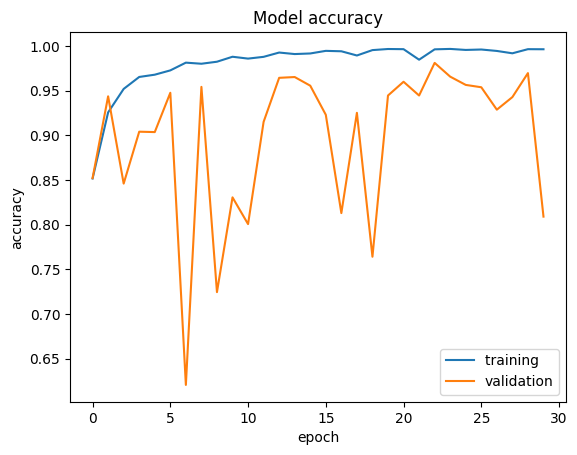

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training ', 'validation'], loc='lower right')
plt.show()

The validation accuracy on the graph can be seen to fluctuate a lot which could indicate overfitting or it could indicate that the learning rate is too large so the model is struggling to converge.

## Experiments

There are many hyperparameters and model changes that can be made and this is a list of the ones that will be focussed on:

- Learning Rate
- Dropout
- Early Stoppage
- Optimizer
- Data augmentation

## Final Model 

After adding in all the different optimal parameters this is what the final model architecture looks like

In [10]:
model = Sequential()

model.add(Input(shape=(224,224,1),name='ImageInput'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2))


model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())


model.add(MaxPool2D((2,2) , strides = 2))



model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2))


model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) ,strides = 2))

model.add(Dropout(0.2))


model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D((2,2) ,  strides = 2))


model.add(Flatten())

model.add(Dense(units = 256 ,kernel_initializer='he_normal', kernel_regularizer='l2', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer = "nadam" , loss = 'CategoricalCrossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

Model Changes :
1. Changed first Convolution layer to have 32 filters
2. Added 2 dropout layers
3. Changed from adam optimizer to nadam
4. Added l2 regularizer and he_normal initialiser
5. Increased number of neurons in first dense layer



# Training with augmentation


In [12]:
x_train = []
y_train = []


for i in range(0,10606):
    img = training_data[i][0]
    image = cv2.imread(str(img))
    re_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    re_img = cv2.resize(re_img,(224,224))
    re_img = re_img.astype(np.float32)/255
    re_img = re_img[..., np.newaxis]
    x_train.append(re_img)
    y = to_categorical(training_data[i][1], num_classes=3)
    y_train.append(y)
    
    augmentation_count = 0

    # if pneumonia
    if argmax(y) == 2:
        augmentation_count = 2

    for count in range(augmentation_count):
        aug_img = augment.augment_image(re_img)
        x_train.append(aug_img)
        y_train.append(y)


    if i%1000==0:
        print('checkpoint reached: ',i)




x_train = np .array(x_train)
y_train = np.array(y_train)

print(x_train.shape)




checkpoint reached:  0
checkpoint reached:  1000
checkpoint reached:  2000
checkpoint reached:  3000
checkpoint reached:  4000
checkpoint reached:  5000
checkpoint reached:  6000
checkpoint reached:  7000
checkpoint reached:  8000
checkpoint reached:  9000
checkpoint reached:  10000
(15668, 224, 224, 1)


The learning rate decay is used here

In [8]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, factor=0.5, verbose = 1)

In [16]:
# Early stopping if val accuracy doesn't improve after 5 epochs
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 5, verbose = 1)

filepath = 'covid_best_model.hdf5'

check = ModelCheckpoint(filepath = filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [learning_rate_reduction,es,check]

history = model.fit(x_train,y_train,batch_size = 16, epochs = 30 , validation_data = (x_val, y_val),callbacks = callbacks)

Epoch 1/30
980/980 [==============================] - ETA: 0s - loss: 1.4529 - accuracy: 0.8619
Epoch 1: val_accuracy improved from -inf to 0.85425, saving model to covid_best_model.hdf5
980/980 [==============================] - 40s 34ms/step - loss: 1.4529 - accuracy: 0.8619 - val_loss: 0.7745 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 2/30
979/980 [============================>.] - ETA: 0s - loss: 0.5030 - accuracy: 0.9212
Epoch 2: val_accuracy did not improve from 0.85425
980/980 [==============================] - 33s 33ms/step - loss: 0.5030 - accuracy: 0.9211 - val_loss: 0.6104 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 3/30
979/980 [============================>.] - ETA: 0s - loss: 0.3322 - accuracy: 0.9458
Epoch 3: val_accuracy improved from 0.85425 to 0.92294, saving model to covid_best_model.hdf5
980/980 [==============================] - 33s 34ms/step - loss: 0.3322 - accuracy: 0.9458 - val_loss: 0.3323 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 4/30
979/980 [==================

In [13]:
# path to healthy validation directory
healthy_test_dir = test_dir / 'HEALTHY'

# path to pneumonia validation directory
pneumonia_test_dir = test_dir / 'PNEUMONIA'

# path to covid validation directory
covid_test_dir = test_dir / 'COVID'

test_data = []


healthy_cases = healthy_test_dir.glob('*.png')
for png in healthy_cases:
    test_data.append((png,0))


pneumonia_cases = pneumonia_test_dir.glob('*.png')
for png in pneumonia_cases:
    test_data.append((png,1))


covid_cases = covid_test_dir.glob('*.png')
for png in covid_cases:
    test_data.append((png,2))
    
test_data = shuffle(test_data)

print(len(test_data))

2276


In [14]:
x_test = []
y_test = []

for i in range(0,2276):
    img = test_data[i][0]
    image = cv2.imread(str(img))
    re_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    re_img = cv2.resize(re_img,(224,224))   
    re_img = re_img.astype(np.float32)/255
    re_img = re_img[..., np.newaxis]
    x_test.append(re_img)
    y = to_categorical(test_data[i][1], num_classes=3)
    y_test.append(y)

x_test = np .array(x_test)
y_test = np.array(y_test)
print(x_test.shape)

(2276, 224, 224, 1)


In [19]:
test_loss, test_score = model.evaluate(x_test, y_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", str(test_score*100))

143/143 [==============================] - 1s 7ms/step - loss: 0.0858 - accuracy: 0.9798
Loss on test set:  0.08580335974693298
Accuracy on test set:  97.97890782356262


## Testing without augmentation

In [10]:
x_train = []
y_train = []


for i in range(0,10606):
    img = training_data[i][0]
    image = cv2.imread(str(img))
    re_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    re_img = cv2.resize(re_img,(224,224))
    re_img = re_img.astype(np.float32)/255
    re_img = re_img[..., np.newaxis]
    x_train.append(re_img)
    y = to_categorical(training_data[i][1], num_classes=3)
    y_train.append(y)
    
    augmentation_count = 0

x_train = np .array(x_train)
y_train = np.array(y_train)

print(x_train.shape)




(10606, 224, 224, 1)


In [11]:
# Early stopping if val accuracy doesn't improve after 5 epochs
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 5, verbose = 1)

filepath = 'covid_best_model.hdf5'

check = ModelCheckpoint(filepath = filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [learning_rate_reduction,es,check]

history = model.fit(x_train,y_train,batch_size = 16, epochs = 30 , validation_data = (x_val, y_val),callbacks = callbacks)

Epoch 1/30
663/663 [==============================] - ETA: 0s - loss: 1.7639 - accuracy: 0.8532
Epoch 1: val_accuracy improved from -inf to 0.71775, saving model to covid_best_model.hdf5
663/663 [==============================] - 32s 38ms/step - loss: 1.7639 - accuracy: 0.8532 - val_loss: 1.2210 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 2/30
663/663 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.9057
Epoch 2: val_accuracy did not improve from 0.71775
663/663 [==============================] - 23s 35ms/step - loss: 0.6294 - accuracy: 0.9057 - val_loss: 4.9896 - val_accuracy: 0.4579 - lr: 0.0010
Epoch 3/30
663/663 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.9303
Epoch 3: val_accuracy improved from 0.71775 to 0.78159, saving model to covid_best_model.hdf5
663/663 [==============================] - 23s 35ms/step - loss: 0.4859 - accuracy: 0.9303 - val_loss: 0.8210 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 4/30
663/663 [==================

In [15]:
test_loss, test_score = model.evaluate(x_test, y_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", str(test_score*100))

143/143 [==============================] - 1s 8ms/step - loss: 0.0558 - accuracy: 0.9859
Loss on test set:  0.0557684525847435
Accuracy on test set:  98.59402179718018


In [16]:
preds = model.predict(x_test, batch_size=16)
pred = np.argmax(preds,axis=1)

y_val_rounded=np.argmax(y_val, axis=1)
y_test_r = np.argmax(y_test,axis=1)



143/143 [==============================] - 1s 6ms/step


[[1521    3    6]
 [   9  191    3]
 [  10    1  532]]


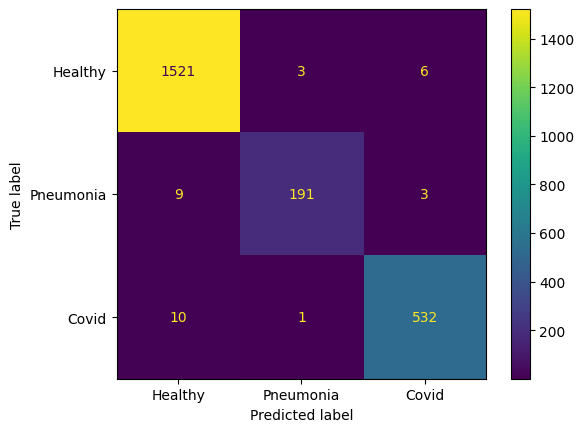

In [45]:
cm = confusion_matrix(y_test_r, pred)

print(cm)

#getting a nicer looking matrix
displaycm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy','Pneumonia','Covid'])
displaycm.plot()
#removing grid lines which makes it difficult to see the numbers
plt.grid(False)
plt.show()


In [41]:
for i in range(0,2276):
    if np.argmax(preds[i]) == 0 and y_test_r[i] == 2:
        print(np.round(preds[i]*100))

[100.   0.   0.]
[89.  0. 10.]
[92.  0.  8.]
[66.  0. 33.]
[100.   0.   0.]
[92.  0.  8.]
[59.  1. 40.]
[84. 14.  2.]
[88.  0. 12.]
[83.  0. 17.]


[[1519    3    8]
 [   9  191    3]
 [   9    1  533]]


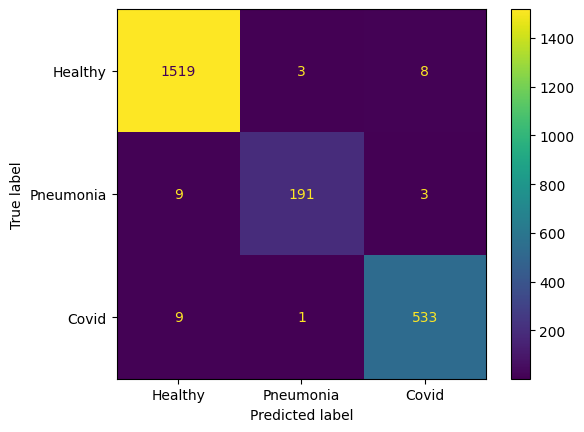

In [51]:
prediction_array = []

for i in preds:
    if argmax(i)==0 and i[argmax(i)] > 0.599:
        prediction_array.append(0)
    elif argmax(i)==0 and i[argmax(i)] < 0.599 and i[2] > i[1]:
        prediction_array.append(2)
    else:
        prediction_array.append(argmax(i))


cm = confusion_matrix(y_test_r, prediction_array)

print(cm)

#getting a nicer looking matrix
displaycm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy','Pneumonia','Covid'])
displaycm.plot()
#removing grid lines which makes it difficult to see the numbers
plt.grid(False)
plt.show()